In [48]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F

s=9
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data wrangling

In [49]:
# data wrangling: load Fashion-MNIST
EMNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])


EMNIST_train = torchvision.datasets.EMNIST(
        '~/data/emnist',
        train=True,
        download=True,
        transform=EMNIST_transform,
        split = 'mnist')



EMNIST_test = torchvision.datasets.EMNIST(
        '~/data/emnist',
        train=False,
        download=False,
        transform=EMNIST_transform,
        split = 'mnist')


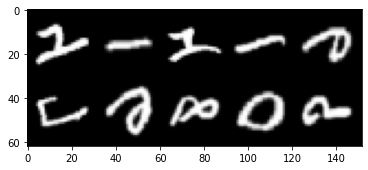

In [50]:
# have a look at the data to verify
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

images = EMNIST_train.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(images, nrow=5))


In [51]:
emnist_train_loader = torch.utils.data.dataloader.DataLoader(
    EMNIST_train,
    batch_size=128,
    shuffle=True
)

emnist_test_loader = torch.utils.data.dataloader.DataLoader(
    EMNIST_test,
    batch_size=128,
    shuffle=False,
)


# Training routine

In [52]:
#set up the network
def NN(num_classes=10):
    
    features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Flatten(),
        torch.nn.Linear(4 * 4 * 32, num_classes)
    )
    return(features)


In [53]:
#set up the training routine
emnist_model = NN(num_classes=10)
loss_function = torch.nn.CrossEntropyLoss()

emnist_train_optimizer = torch.optim.Adam(emnist_model.parameters(), lr=1e-3, weight_decay=5e-4)
#dont use SGD, it is way worse than Adam here
EMNIST_PATH = "EMNIST_weights_seed={}.pth".format(s)
#print(FMNIST_PATH)

In [54]:
# helper function to get accuracy
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()


In [55]:
# Write the training routine and save the model at FMNIST_PATH

def train(verbose=False, num_iter=5):
    max_len = len(emnist_train_loader)
    for iter in range(num_iter):
        for batch_idx, (x, y) in enumerate(emnist_train_loader):
            output = emnist_model(x)

            accuracy = get_accuracy(output, y)

            loss = loss_function(output, y)
            loss.backward()
            emnist_train_optimizer.step()
            emnist_train_optimizer.zero_grad()

            if verbose:
                if batch_idx % 10 == 0:
                    print(
                        "Iteration {}; {}/{} \t".format(iter, batch_idx, max_len) +
                        "Minibatch Loss %.3f  " % (loss) +
                        "Accuracy %.0f" % (accuracy * 100) + "%"
                    )

    print("saving model at: {}".format(EMNIST_PATH))
    torch.save(emnist_model.state_dict(), EMNIST_PATH)

In [56]:
#after training it once, comment this out to save time if you rerun the entire script
#train(verbose=True, num_iter=5)


In [57]:
#predict in distribution
EMNIST_PATH = "EMNIST_weights_seed={}.pth".format(s)

emnist_model = NN(num_classes=10)
print("loading model from: {}".format(EMNIST_PATH))
emnist_model.load_state_dict(torch.load(EMNIST_PATH))
emnist_model.eval()

acc = []

max_len = len(emnist_test_loader)
for batch_idx, (x, y) in enumerate(emnist_test_loader):
        output = emnist_model(x)
        accuracy = get_accuracy(output, y)
        if batch_idx % 10 == 0:
            print(
                "Batch {}/{} \t".format(batch_idx, max_len) + 
                "Accuracy %.0f" % (accuracy * 100) + "%"
            )
        acc.append(accuracy)
    
avg_acc = np.mean(acc)
print('overall test accuracy on EMNIST: {:.02f} %'.format(avg_acc * 100))

loading model from: EMNIST_weights_seed=9.pth
Batch 0/79 	Accuracy 99%
Batch 10/79 	Accuracy 98%
Batch 20/79 	Accuracy 99%
Batch 30/79 	Accuracy 100%
Batch 40/79 	Accuracy 100%
Batch 50/79 	Accuracy 100%
Batch 60/79 	Accuracy 99%
Batch 70/79 	Accuracy 99%
overall test accuracy on EMNIST: 98.88 %


# Laplace approximation of the weights
* we use the BackPACK package to approximate the Hessian of the parameters. Especially look at the DiagHessian() method.
* we do one iteration over the entire training set and use the mean of the Hessian of the mini-batches as the best approximation of the Hessian.
* we add a prior variance to our Hessian. The precision is 1 over the variance. we use a prior precision of 10, 20, and 50 (or variance of 1/10, 1/20, 1/50).
    * edit: I will use precicisions of 10, 60, 120, 1000 in the following


In [58]:
def get_Hessian_NN(model, train_loader, prec0, device='cpu', verbose=True):
    lossfunc = torch.nn.CrossEntropyLoss()

    extend(lossfunc, debug=False)
    extend(model, debug=False)

    Cov_diag = []
    for param in model.parameters():
        ps = param.size()
        print("parameter size: ", ps)
        Cov_diag.append(torch.zeros(ps, device=device))
        #print(param.numel())

    #var0 = 1/prec0
    max_len = len(train_loader)

    with backpack(DiagHessian()):

        for batch_idx, (x, y) in enumerate(train_loader):

            if device == 'cuda':
                x, y = x.float().cuda(), y.long().cuda()

            model.zero_grad()
            lossfunc(model(x), y).backward()

            with torch.no_grad():
                # Hessian of weight
                for idx, param in enumerate(model.parameters()):

                    H_ = param.diag_h
                    #add prior here
                    H_ += prec0 * torch.ones(H_.size())
                    H_inv = torch.sqrt(1/H_) #<-- standard deviation
                    #H_inv = 1/H_              #<-- variance 

                    rho = 1-1/(batch_idx+1)

                    Cov_diag[idx] = rho*Cov_diag[idx] + (1-rho)* H_inv
            
            if verbose:
                print("Batch: {}/{}".format(batch_idx, max_len))
    
    return(Cov_diag)

In [59]:
#EMNIST_NN_Std_prec_00001 = get_Hessian_NN(model=emnist_model, train_loader=emnist_train_loader, prec0=0.0001,verbose=False)
#torch.save(EMNIST_NN_Std_prec_00001, 'Hessian_prec00001_seed_EMNIST.pth')

In [60]:
EMNIST_NN_Std_prec_00001 = torch.load('Hessian_prec00001_EMNIST.pth')

## Now we want to look at the single layers of our network, and how they behave w.r.t. the variance
* every tensor represents one of the six layers of out network


## visualize the first layer of our networks in a heatmap
* therefore we put the tensor in the right form/dimensions, by concatening all of its included arrays and then reshaping the tensor


In [61]:
import seaborn as sns
def visualize(tensor):
    output = tensor[0][0]
    for i in range(1, len(tensor[0])):
        output = np.concatenate((output, tensor[0][i]))
    output = output.transpose(2, 0, 1).reshape(5, -1)
    heatmap = sns.heatmap(output)
    plt.xticks = (np.arange(0, step=20))
    plt.show()
   

In [62]:
#visualize(MNIST_NN_Hessian_diag_10)

In [63]:
def meancalc(Hessian_diag_x):
    i = 0 
    for name, parameter in emnist_model.named_parameters():
        mean = torch.mean(Hessian_diag_x[i])
        print("mean variance of layer {0:s}: {1:.4f}".format(name, mean.item()))
        i += 1
    


In [64]:
meancalc(Hessian_diag_x=EMNIST_NN_Std_prec_00001)

mean variance of layer 0.weight: 28.7454
mean variance of layer 0.bias: 13.9820
mean variance of layer 3.weight: 68.3070
mean variance of layer 3.bias: 40.1176
mean variance of layer 7.weight: 31.2478
mean variance of layer 7.bias: 26.6472


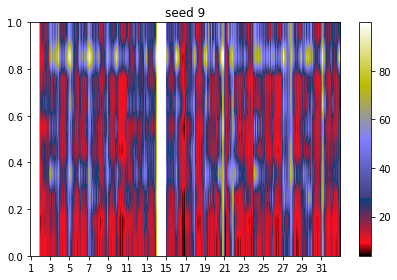

In [70]:
plt.imshow(EMNIST_NN_Std_prec_00001[4], cmap='gist_stern',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_title('seed {}'.format(s))
plt.colorbar()
plt.tight_layout()
plt.show()
#plt.savefig('linear_seed1000={}'.format(s))

#plt.hist(EMNIST_NN_Std_prec_00001[4])

In [66]:
"""
mnist_number = 9
linear_layer_index = 4 #linear layer has index 4
linear_layer = MNIST_NN_Hessian_diag_120[linear_layer_index][mnist_number]

#reshape the flattened array to 32* (4x4)
layer_split = np.array_split(np.array(linear_layer), 32)
for i in range(len(layer_split)-1):
    layer_split[i] = np.reshape(layer_split[i], (4, -1))

#plot setup
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

#iterate through the features and plot them
for i in range(len(layer_split)):
    layer_split[i] = np.reshape(layer_split[i], (4, -1))
    axs[i].imshow(layer_split[i])
    axs[i].set_title('feature '+str(i+1))
"""

"\nmnist_number = 9\nlinear_layer_index = 4 #linear layer has index 4\nlinear_layer = MNIST_NN_Hessian_diag_120[linear_layer_index][mnist_number]\n\n#reshape the flattened array to 32* (4x4)\nlayer_split = np.array_split(np.array(linear_layer), 32)\nfor i in range(len(layer_split)-1):\n    layer_split[i] = np.reshape(layer_split[i], (4, -1))\n\n#plot setup\nfig, axs = plt.subplots(4,8, figsize=(20, 15))\nfig.subplots_adjust(hspace = .001, wspace=.001)\naxs = axs.ravel()\n\n#iterate through the features and plot them\nfor i in range(len(layer_split)):\n    layer_split[i] = np.reshape(layer_split[i], (4, -1))\n    axs[i].imshow(layer_split[i])\n    axs[i].set_title('feature '+str(i+1))\n"

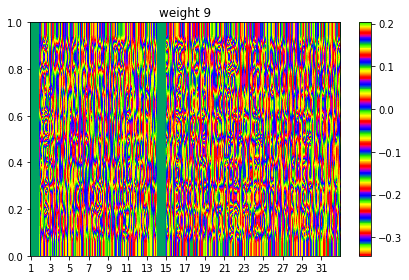

In [71]:
for name, parameters in emnist_model.named_parameters():
    if name == '7.weight':
        a = parameters

b = a.detach().numpy()

plt.imshow(b, cmap='prism',extent=[0,512,0,1],  aspect='auto')
ax = plt.gca()
ax.set_xticks(np.arange(1, 512, 32));
ax.set_xticklabels(np.arange(1, 32, 2));
ax.set_title('weight {}'.format(s))
plt.colorbar()
plt.tight_layout()
im = plt.show()
#plt.hist(b)

In [72]:
to_hist = []
target_feature = 9
for i in range(10):
    weight = a[i].detach().numpy()
    weight = np.array_split(np.array(weight), 32)
    to_hist.append(weight[target_feature -1])
#plt.hist(to_hist)

In [69]:

#observe = [1, 8, 13, 14, 17, 24]
#f,c = plt.subplots(3,2)
#plt.figure(figsize=(20,20))
#c = c.ravel()
#for i in range(10):
#    test = np.array_split(a[i].detach().numpy(), 32)
#for idx, ax in enumerate(c):
#    ax.set_title(str(observe[idx] +1))
#    ax.hist(test[observe[idx]])
#plt.tight_layout()
        
    
#for idx,ax in enumerate(a):
 #   ax.hist(test[observe[idx]])
 

# visualize the second conv layer kernels

### first visualize the uncertaintys of the kernels

6


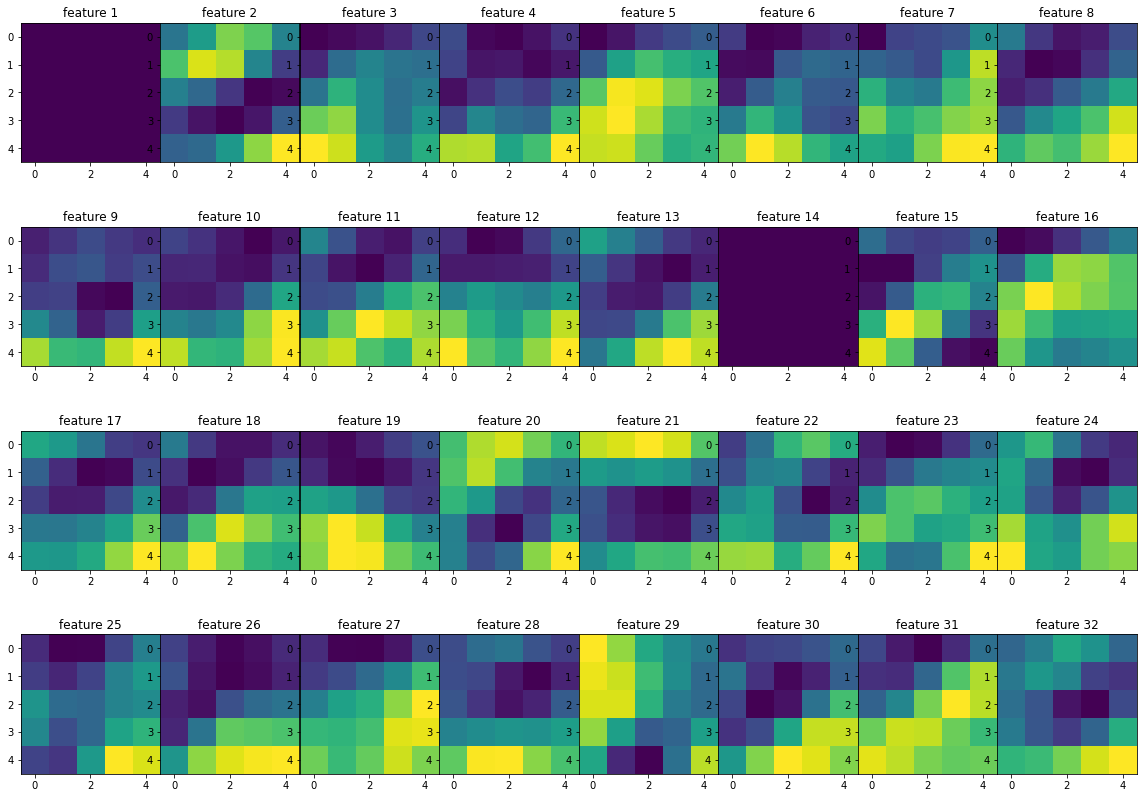

In [85]:
from random import randint

#choose a random between 0 and 31 for 2nd dimension
j = randint(0, 31)

fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
print(j)
for i in range(32):
    #for j in range(32):
    axs[i].imshow(EMNIST_NN_Std_prec_00001[2][i][j])
    axs[i].set_title('feature '+str(i+1))

### in kernels with high uncertainty the biases are maximal (100 for precision 0.0001)

In [75]:
print(EMNIST_NN_Std_prec_00001[3])

tensor([100.0000,  18.4359,  40.6711,  33.9492,  50.7072,  42.9428,  32.4536,
         33.8575,  31.8324,  20.8747,  32.5482,  39.0619,  58.8334, 100.0000,
         46.4394,  25.7914,  34.8467,  31.6409,  47.5839,  31.6133,  29.3898,
         21.1349,  29.9845,  24.3318,  23.5601,  38.9891,  58.8692,  35.6215,
         22.5918,  47.1880,  60.1552,  37.8635])


## Now viualize the weights of the kernels in the second conv layer (3.weight)

13


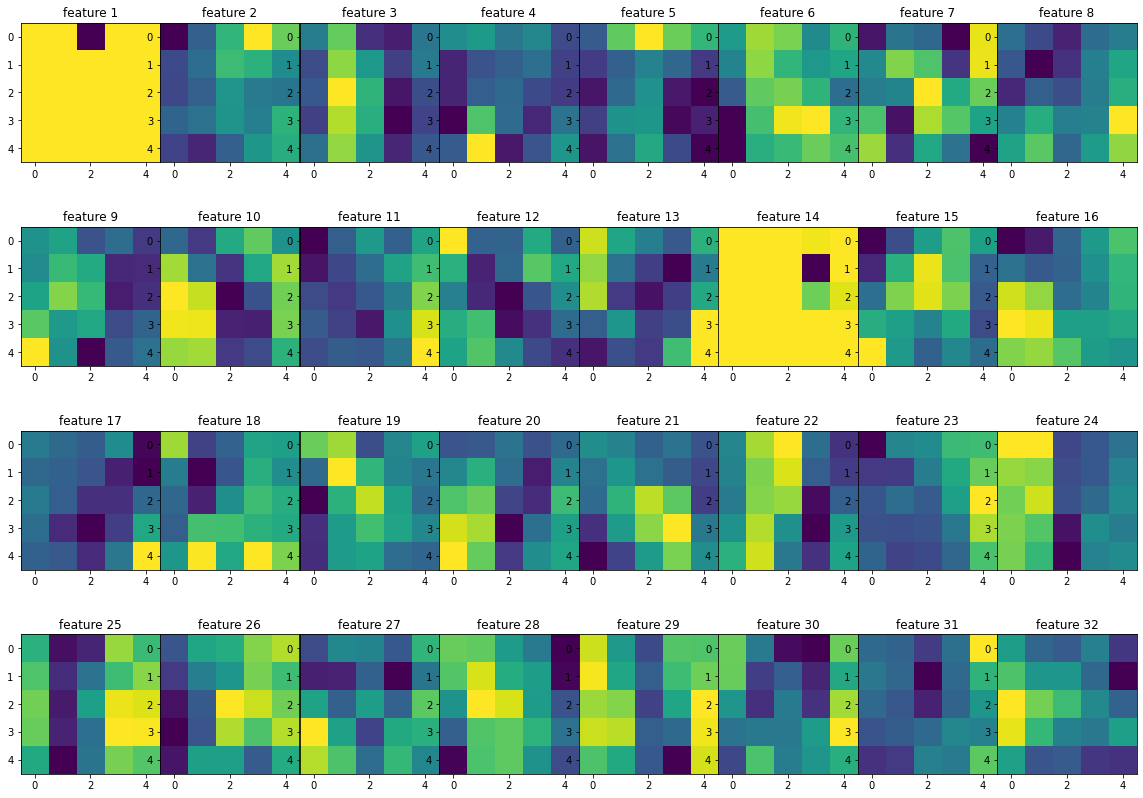

In [90]:
for name, parameters in emnist_model.named_parameters():
    if name == '3.weight':
        params = parameters

params_arr = params.detach().numpy()
#print(params_arr[31][2])
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
#choose random number between 0 and 31 for 2nd dimension
j = randint(0, 31)
#j = …
print(j)
for i in range(32):
    #for j in range(32):
    axs[i].imshow(params_arr[i][j])
    axs[i].set_title('feature '+str(i+1))
    
#interesting j values: 10, 13

### look at the biases of the 3rd layer (3.bias)

In [91]:
for name, parameters in emnist_model.named_parameters():
    if name == '3.bias':
        params = parameters

params_arr = params.detach().numpy()
print(params_arr)
#plt.hist(params_arr)

[-0.00056264  0.09776124 -0.01770498 -0.04949411 -0.02568186 -0.00485916
  0.00053978 -0.0515428  -0.06924909 -0.04453445  0.02372086 -0.04246574
 -0.0065864  -0.00017246  0.00117638  0.01558267 -0.01662074 -0.04078482
 -0.02447529 -0.03566293  0.0565535   0.00972877  0.00015687  0.02772833
 -0.00693917 -0.04182134 -0.03829033 -0.06075083  0.07438803 -0.03683714
  0.00522729 -0.01139335]


## visualize the first conv layers kernels

### first visualize the uncertaintys of the kernels

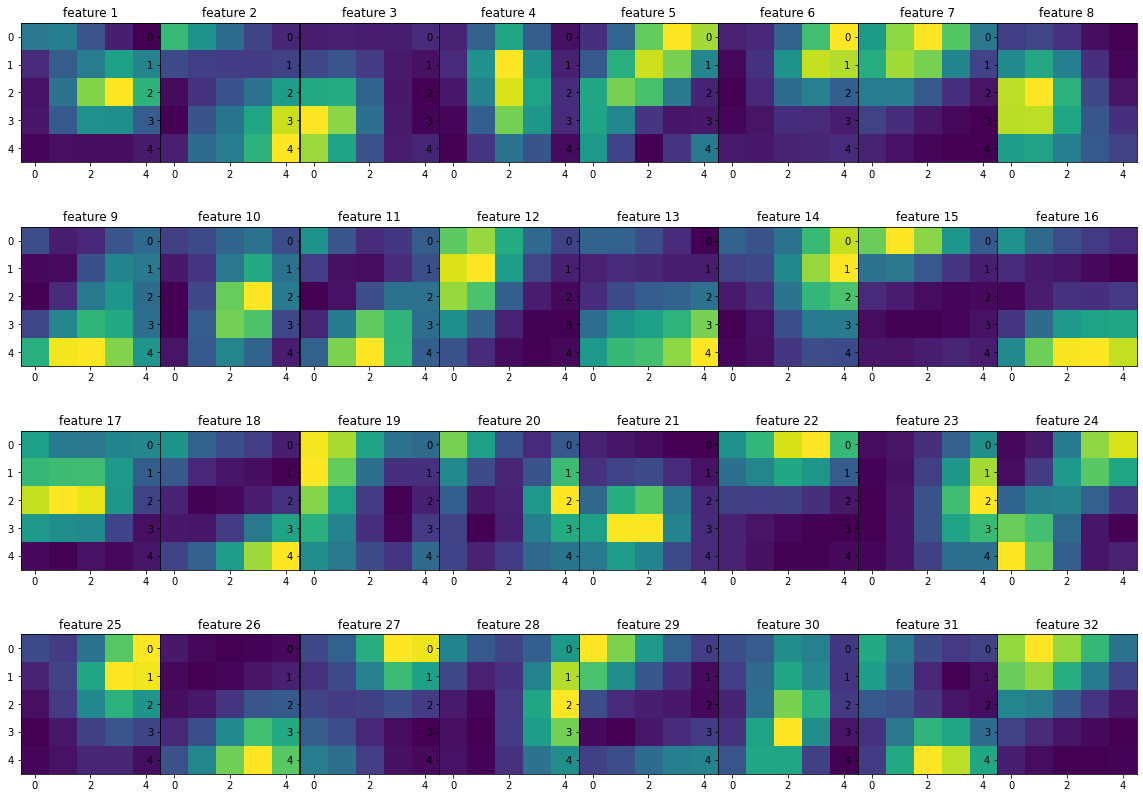

In [92]:
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    #for j in range(32):
    axs[i].imshow(EMNIST_NN_Std_prec_00001[0][i][0])
    axs[i].set_title('feature '+str(i+1))

In [93]:
print(EMNIST_NN_Std_prec_00001[1])

tensor([15.6442, 26.7269,  8.8056,  4.5080, 18.6404, 10.7259,  5.1986,  6.6167,
        15.9084,  5.7726, 18.1421,  9.7097, 31.7787, 10.3024,  7.7233, 23.9181,
        14.5915, 28.9939, 31.6664, 13.9558,  6.4843,  7.5572,  4.2561,  6.5449,
        11.9944,  7.2070, 18.1107,  8.7289, 26.2578,  4.2950, 24.8452, 11.8134])


## now visualize the weights of kernels in first conv layer

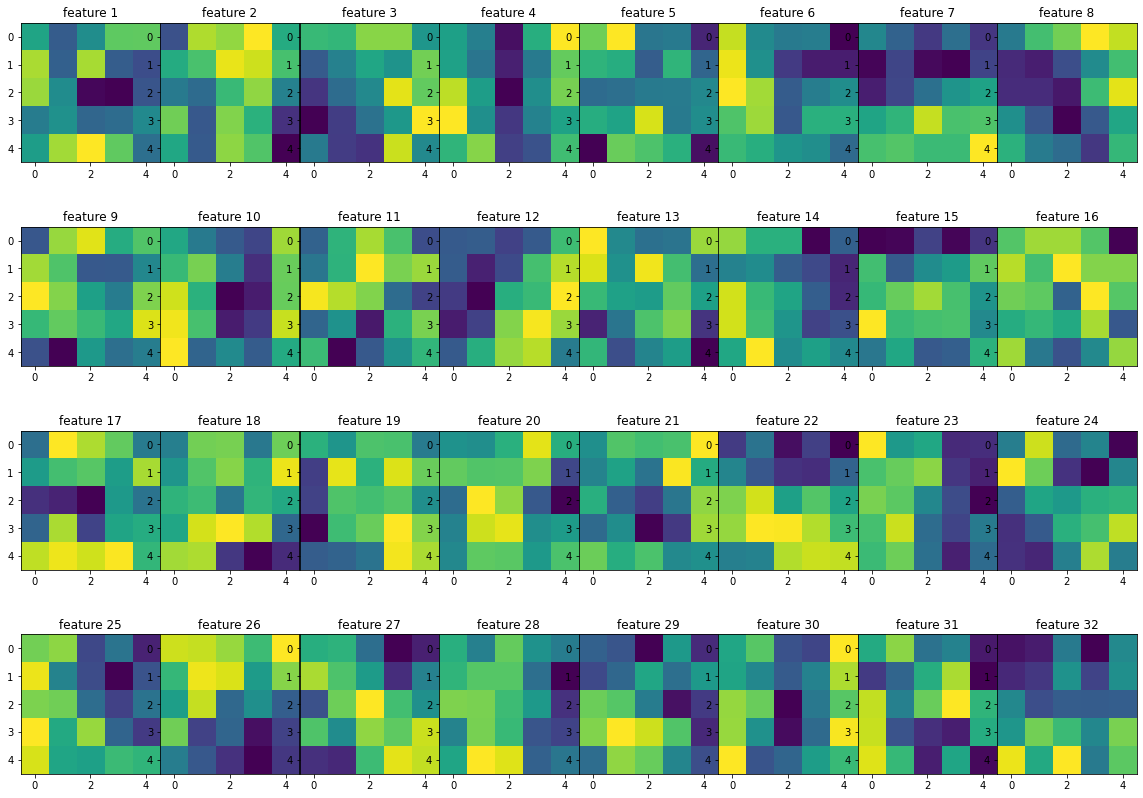

In [94]:
for name, parameters in emnist_model.named_parameters():
    if name == '0.weight':
        params = parameters

params_arr = params.detach().numpy()
#print(params_arr[31][2])
fig, axs = plt.subplots(4,8, figsize=(20, 15))
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    #for j in range(32):
    axs[i].imshow(params_arr[i][0])
    axs[i].set_title('feature '+str(i+1))